# TensorFlow的分类器模型构建(监督学习)归一化后--回调函数
使用数据集-> Fashion Mnist

In [1]:
import os
from tensorflow import keras
import tensorflow as tf
import sklearn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# 这串代码让图像直接显示在Notebook里而不是单独打开一个窗口
%matplotlib inline

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

# 训练集 验证集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

# 归一化前的max和min
print(np.max(x_train), np.min(x_train))

255 0


## 数据归一化
### 原理
> $x = \frac{x - u} {std}$  
  > 其中u 是均值， std 是方差
### sklearn的归一化函数
首先用`StandardScaler()`创建一个对象  
再调用它的方法`.fit_transorm()`  
因为这个函数的参数接受只`[样本数 , 特征]`所以我们要先reshape它  
- StandardScaler()类的transform要求如下:  
> Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.  

**x_train: [None , 28 , 28] ->[None , 784]**

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

# 归一化后的max和min
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.0231433 -0.8105136


In [4]:
model = tf.keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [5]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='sgd',
    metrics=["accuracy"]
)

## 回调函数
因为回调函数是在训练的过程中调用的，所有我们在fit的时候添加
```py
tf.keras.callbacks
```

- [TensorFlow回调函数官方API介绍](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/callbacks)
### 常用回调函数
    1. [EarlyStopping](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/callbacks/EarlyStopping)  
        当你的模型训练的loss不再下降的时候可以提前停止训练
 
  `min_delta` 是一个阈值， 如果loss在这个阈值内则会触发**EarlyStopping**  
   `patience` 出发几次EarlyStopping后停止训练模型
    2. [ModelCheckpoint](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/callbacks/ModelCheckpoint)  
        可以记录在训练过程中某几个时间点模型的参数
    3. [TensorBoard](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/callbacks/TensorBoard)
        非常重要的模型训练时效果的可视化工具

In [6]:
# 记录callbacks的文件夹与文件
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 'fashion_mnist_model.h5')

#
history = model.fit(x_train_scaled, y_train,
                    epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience = 5 , min_delta = 1e-3),
                        keras.callbacks.ModelCheckpoint(
                            output_model_file, save_best_only=True),
                        keras.callbacks.TensorBoard(logdir)
                    ]
                    )

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 60us/sample - loss: 0.9347 - accuracy: 0.6871 - val_loss: 0.6293 - val_accuracy: 0.7918
Epoch 2/10
55000/55000 [==============================] - 3s 60us/sample - loss: 0.5884 - accuracy: 0.7968 - val_loss: 0.5299 - val_accuracy: 0.8188
Epoch 3/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.5174 - accuracy: 0.8201 - val_loss: 0.4848 - val_accuracy: 0.8336
Epoch 4/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.4792 - accuracy: 0.8315 - val_loss: 0.4595 - val_accuracy: 0.8448
Epoch 5/10
55000/55000 [==============================] - 2s 36us/sample - loss: 0.4540 - accuracy: 0.8399 - val_loss: 0.4381 - val_accuracy: 0.8532
Epoch 6/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.4358 - accuracy: 0.8459 - val_loss: 0.4260 - val_accuracy: 0.8542
Epoch 7/10
55000/55000 [==============================] -

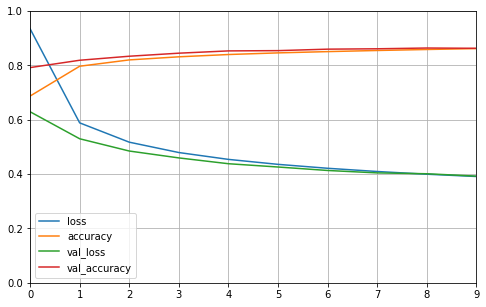

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()


plot_learning_curves(history)

In [10]:
# 使用测试集验证模型的准确度
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 0s 24us/sample - loss: 0.4274 - accuracy: 0.8475


[0.4273928413629532, 0.8475]